# True Reach Estimator

We are looking to build an estimator around instagram users true reach and impressions. This data is accessible through the business api but in Q1 2018 Instagram blocked influencer marketing teams from this endpoint. We are able to collect a sample of this data to see if there working correlations between currently public data and true reach/impressions. 

Data: the CSV we have contains one year worth of data from 5,000 influencer level Instagram users. 

## The goal: 
Given the public data points create an accurate estimate of each posts reach and impressions. The ideal would be as accurate as possible, but a 10% range will work for the business. 

## TRIAL 6 - Logarithmic Transformations

In this trial, we transform the data to follow a more normal distribution before building the model. We then used a Min/Max scaling process with Sklearn to shift the distributions to a mean of zero and a standard deviation of 1. 


In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
%matplotlib inline
import warnings 
warnings.filterwarnings('ignore')

Pull in the CSV file

In [2]:
df = pd.read_csv('Impression-estimator-data.csv')

Add column labels

In [3]:
df.columns = ['user_id', 'instagram_id', 'followers', 'published', 'likes', 'comments', 'impressions', 'reach', 'saves']

First, look at the data

In [4]:
df.head()
df.user_id.nunique()

5093

In [5]:
len(df)

728018

Drop columns that are unneeded.

In [6]:
df2 = df.drop(['user_id', 'instagram_id', 'saves'], axis=1)

Anyone with very little reach will skew the  data. It's probably a bot. 

In [7]:
df2 = df2[(df2['reach']>300)]

We have decided to remove rows that have less than 100 followers. This not only helps eliminate outliers but in the data collection there were many rows with zero followers and high numbers in reach. This data clearly is not correct 

In [8]:
df2 = df2[(df2['followers']>100)]

Setting comments to greater than zero to avoid zero division errors

In [9]:
df2 = df2[(df2['comments']>=1)]

Remove rows with less than 100 likes to eliminate outliers.

In [10]:
df2 = df2[(df2['likes']>=100)]

Remove wierd situations where there are more comments, likes than reach.

In [11]:
print(len(df2))
df2 = df2.loc[(df2.likes<df2.reach)]
df2 = df2.loc[(df2.comments<df2.reach)]
print(len(df2))

465850
457492


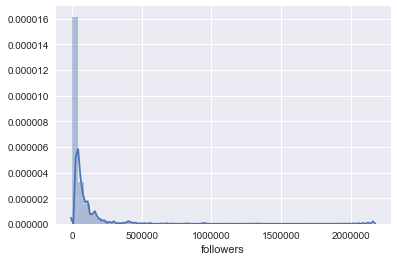

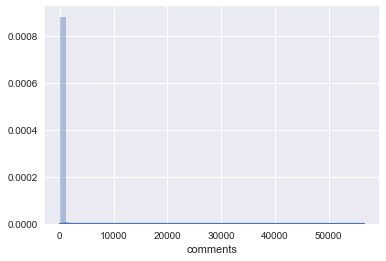

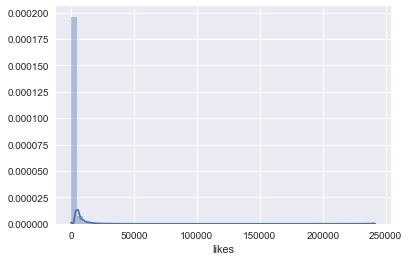

In [12]:
# fig, axs = plt.subplots(1,3, squeeze=False)

sns.distplot(df2.followers)
plt.show()
sns.distplot(df2.comments)
plt.show()
sns.distplot(df2.likes)
plt.show()

Further we used Statsmodels to create an OLS model. This allows us to see all the import statistics and values associated with the three variables together. 

In [13]:
lr_model = ols(formula='reach~followers + likes + comments', data=df2).fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  reach   R-squared:                       0.628
Model:                            OLS   Adj. R-squared:                  0.628
Method:                 Least Squares   F-statistic:                 2.570e+05
Date:                Thu, 07 Mar 2019   Prob (F-statistic):               0.00
Time:                        20:03:29   Log-Likelihood:            -5.1761e+06
No. Observations:              457492   AIC:                         1.035e+07
Df Residuals:                  457488   BIC:                         1.035e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1166.9887     33.740    -34.587      0.000   -1233.119   -1100.859
followers      0.0160      0.000     41.216      0.000       0.015       0.017
likes          8.5321      0.014    602.351      0.000       8.504       8.560
comments      -3.2288      0.169    -19.096      0.000      -3.560      -2.897
==============================================================================
Omnibus:                  1221671.277   Durbin-Watson:                   1.091
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     181895798912.767
Skew:                          31.557   Prob(JB):                         0.00
Kurtosis:                    3091.407   Cond. No.                     1.33e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.33e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Text(0.5, 1.0, 'Followers Correlation plot')

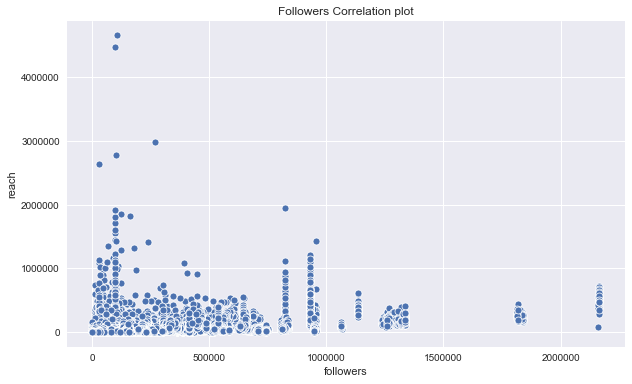

In [14]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=df2.followers, y=df2.reach)
plt.xlabel('followers')
plt.ylabel('reach')
plt.title("Followers Correlation plot")
# plt.xlim(0,75_000)
# plt.ylim(0, 1_000_000)

Text(0.5, 1.0, 'Likes Correlation plot')

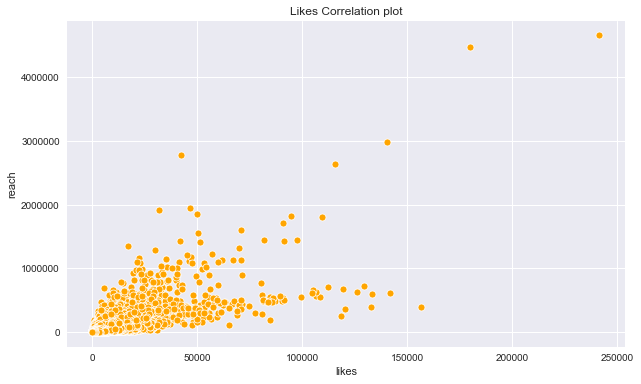

In [15]:
plt.figure(figsize=(10,6))
sns.scatterplot(y=df2.reach, x=df2.likes, color='orange')
plt.xlabel('likes')
plt.ylabel('reach')
plt.title("Likes Correlation plot")

Text(0.5, 1.0, ' Comments Correlation plot')

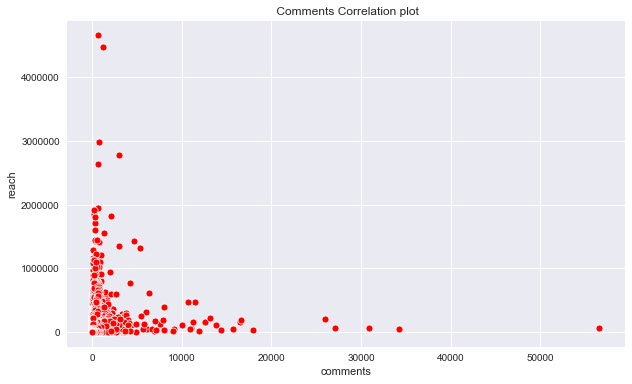

In [16]:
plt.figure(figsize=(10,6))
sns.scatterplot(y=df2.reach, x=df2.comments, color='red')
plt.xlabel('comments')
plt.ylabel('reach')
plt.title(" Comments Correlation plot")

# Logarithmic Transformation
Here we will reassign the values of our feature with the numpy log method:

In [17]:
import numpy as np
df["followers"] = np.log(df['followers'])
df["comments"] = np.log(df["comments"])
df["likes"] = np.log(df["likes"])

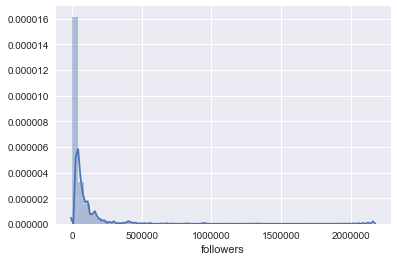

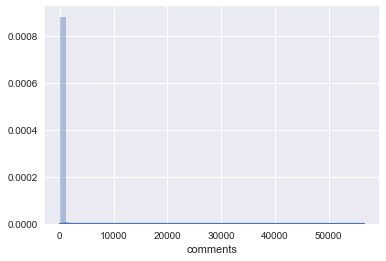

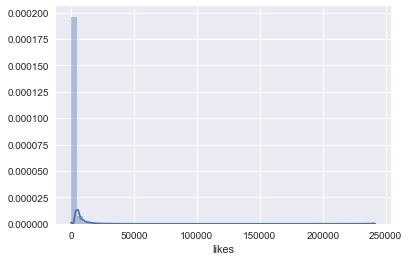

In [18]:
sns.distplot(df2.followers)
plt.show()
sns.distplot(df2.comments)
plt.show()
sns.distplot(df2.likes)
plt.show()

# Standardization and Min-Max scaling

In [19]:
std_scale = preprocessing.StandardScaler().fit(df2[['followers', 'likes', 'comments']])
df_std = std_scale.transform(df2[['followers', 'likes', 'comments']])

minmax_scale = preprocessing.MinMaxScaler().fit(df2[['followers', 'likes', 'comments']])
df_minmax = minmax_scale.transform(df2[['followers', 'likes', 'comments']])

In [20]:
print('Mean after standardization:\nfollowers={:.2f}, Likes={:.2f}, comments={:.2f}'
      .format(df_std[:,0].mean(), df_std[:,1].mean(), df_std[:,2].mean()))
print('\nStandard deviation after standardization:\nfollowers={:.2f}, Likes={:.2f}, comments={:.2f}'
      .format(df_std[:,0].std(), df_std[:,1].std(), df_std[:,2].std()))

Mean after standardization:
followers=0.00, Likes=0.00, comments=-0.00

Standard deviation after standardization:
followers=1.00, Likes=1.00, comments=1.00


In [21]:
print('Mean after standardization:\nfollowers={:.2f}, Likes={:.2f}, comments={:.2f}'
      .format(df_minmax[:,0].min(), df_minmax[:,1].min(), df_minmax[:,2].min()))
print('\nStandard deviation after standardization:\nfollowers={:.2f}, Likes={:.2f}, comments={:.2f}'
      .format(df_minmax[:,0].max(), df_minmax[:,1].max(), df_minmax[:,2].max()))

Mean after standardization:
followers=0.00, Likes=0.00, comments=0.00

Standard deviation after standardization:
followers=1.00, Likes=1.00, comments=1.00


In [22]:
min_max = pd.DataFrame(df_minmax, columns=['mm_followers', 'mm_likes', 'mm_comments'])

In [23]:
min_max.head()

,mm_followers,mm_likes,mm_comments
0,0.031419,0.000029,0.000000
1,0.031419,0.000924,0.000000
2,0.031443,0.002303,0.000194
3,0.031253,0.008052,0.000442
4,0.031265,0.005703,0.001096


In [24]:
df2.reset_index(inplace=True)

In [25]:
len(min_max)

457492

In [26]:
df3 = pd.concat([df2, min_max], axis=1)

In [27]:
df2 = df3

In [28]:
df2.head()

,index,followers,published,likes,comments,impressions,reach,mm_followers,mm_likes,mm_comments
0,0,68172,2018-06-18T01:26:44.000+00:00,107,1,2301,1782,0.031419,0.000029,0.000000
1,1,68172,2018-06-17T18:47:24.000+00:00,323,1,9563,8131,0.031419,0.000924,0.000000
2,3,68223,2018-06-18T16:44:25.000+00:00,656,12,11360,9082,0.031443,0.002303,0.000194
3,4,67812,2018-05-30T03:22:11.000+00:00,2044,26,100970,85215,0.031253,0.008052,0.000442
4,5,67838,2018-06-07T20:18:38.000+00:00,1477,63,42470,36095,0.031265,0.005703,0.001096


In [29]:
lr_model = ols(formula='reach~mm_followers + mm_likes + mm_comments', data=df2).fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  reach   R-squared:                       0.628
Model:                            OLS   Adj. R-squared:                  0.628
Method:                 Least Squares   F-statistic:                 2.570e+05
Date:                Thu, 07 Mar 2019   Prob (F-statistic):               0.00
Time:                        20:03:44   Log-Likelihood:            -5.1761e+06
No. Observations:              457492   AIC:                         1.035e+07
Df Residuals:                  457488   BIC:                         1.035e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     -315.1969     33.553     -9.394      0.000    -380.959    -249.434
mm_followers  3.476e+04    843.428     41.216      0.000    3.31e+04    3.64e+04
mm_likes       2.06e+06   3419.791    602.351      0.000    2.05e+06    2.07e+06
mm_comments  -1.827e+05   9568.405    -19.096      0.000   -2.01e+05   -1.64e+05
==============================================================================
Omnibus:                  1221671.277   Durbin-Watson:                   1.091
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     181895798912.766
Skew:                          31.557   Prob(JB):                         0.00
Kurtosis:                    3091.407   Cond. No.                         328.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Findings:** After the log transfrom and min/max scaling we see that the new model retains the same R-squared value, but the coefficients and intercept look more normal. 

## Scatterplots after transform and scale: 

Text(0.5, 1.0, 'Followers Correlation plot')

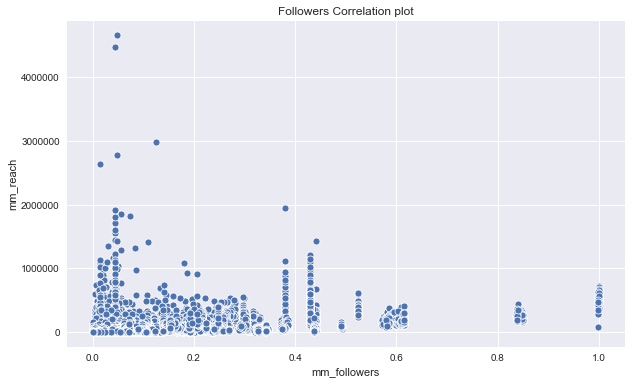

In [30]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=df2.mm_followers, y=df2.reach)
plt.xlabel('mm_followers')
plt.ylabel('mm_reach')
plt.title("Followers Correlation plot")

Text(0.5, 1.0, 'Likes Correlation plot')

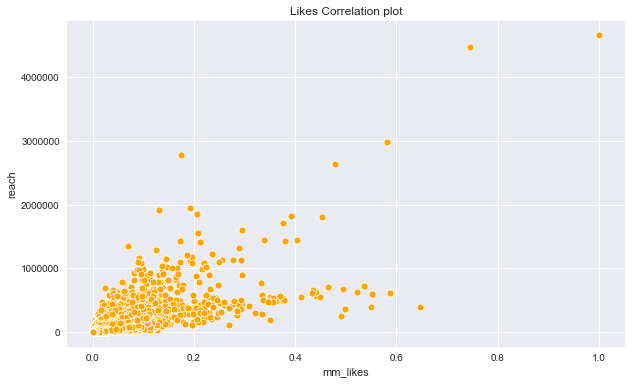

In [31]:
plt.figure(figsize=(10,6))
sns.scatterplot(y=df2.reach, x=df2.mm_likes, color='orange' )
plt.xlabel('mm_likes')
plt.ylabel('reach')
plt.title("Likes Correlation plot")

Text(0.5, 1.0, ' Comments Correlation plot')

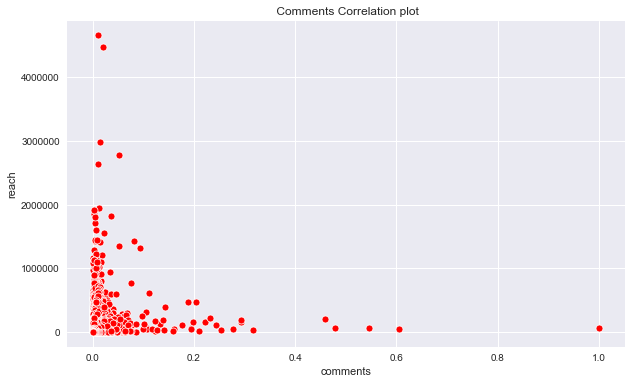

In [32]:
plt.figure(figsize=(10,6))
sns.scatterplot(y=df2.reach, x=df2.mm_comments, color='red')
plt.xlabel('comments')
plt.ylabel('reach')
plt.title(" Comments Correlation plot")

In [33]:
from sklearn.linear_model import LinearRegression
regression_1 = LinearRegression()
regression_2 = LinearRegression()
regression_3 = LinearRegression()

likes = df2["mm_likes"].values.reshape(-1, 1)
comments = df2["mm_comments"].values.reshape(-1, 1)
followers = df2["mm_followers"].values.reshape(-1, 1)

regression_1.fit(likes, df2["reach"])
regression_2.fit(comments, df2["reach"])
regression_3.fit(followers, df2["reach"])

# Make predictions using the testing set
pred_1 = regression_1.predict(likes)
pred_2 = regression_2.predict(comments)
pred_3 = regression_3.predict(followers)

# The coefficients
print(regression_1.coef_)
print(regression_2.coef_)
print(regression_3.coef_)

[2140648.53789813]
[2024434.14329354]
[387566.26652683]


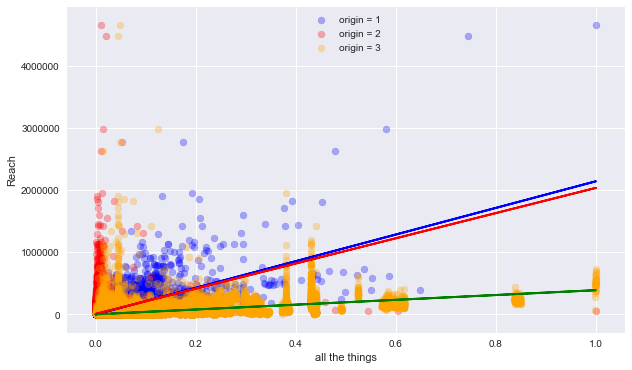

In [34]:
# Plot outputs
plt.figure(figsize=(10,6))

plt.scatter(likes, df2["reach"],  color='blue', alpha = 0.3, label = "origin = 1")
plt.scatter(comments, df2["reach"],  color='red', alpha = 0.3, label = "origin = 2")
plt.scatter(followers, df2["reach"],  color='orange', alpha = 0.3, label = "origin = 3")

plt.plot(likes, pred_1,  color='blue', linewidth=2)
plt.plot(comments, pred_2,  color='red', linewidth=2)
plt.plot(followers, pred_3,  color='green', linewidth=2)
plt.ylabel("Reach")
plt.xlabel("all the things")
plt.legend();

## Summary of trial 6

Scaling doesn't matter here. Our log transform did not change our model in a sigificant way. 